# AirBnb Time Series Analysis

There are many aspects of a company's stock value that may be of interest to the shareholder. First, we will try to predict the closing stock value for AirBnb. Then we'll apply similar methods to create models to predict the Highest stock value.

## Install Required Libraries

In [1]:
pip install pandas==1.3.4 numpy==1.22.3 seaborn==0.9.0 matplotlib==3.5.1 scikit-learn==1.0.2

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
import os
import copy

import numpy as np
from numpy.core.fromnumeric import reshape
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from numpy.random import rand

from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
#import tensorflow as tf
    
#import keras
#from keras import layers,Input,Sequential 
#from keras.layers import Dense,Flatten,Reshape,Conv2DTranspose,Conv2D, BatchNormalization
#from keras.models import Model
#from tensorflow.keras.optimizers import SGD

#from keras.layers import Conv2D
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt

Here is a function that will create feature columns for the year month and day of week of the Airbnb stock value

In [97]:
def create_features_datetime(df):
    
    df['Year']=df.index.year
    df['Month']=df.index.month
    df['dow']=df.index.day_of_week
    
    return df

## Prepare Dataset

In [4]:
df = pd.read_csv("../data/ABNB.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800
1,2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100
2,2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400
3,2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600
4,2020-12-17,143.000000,152.449997,142.669998,147.050003,147.050003,15054700


The date column will be set as the index of the dataframe

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800
2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100
2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400
2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600
2020-12-17,143.000000,152.449997,142.669998,147.050003,147.050003,15054700


Here is a line plot of the open and close stock values for the 2021-22 year

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


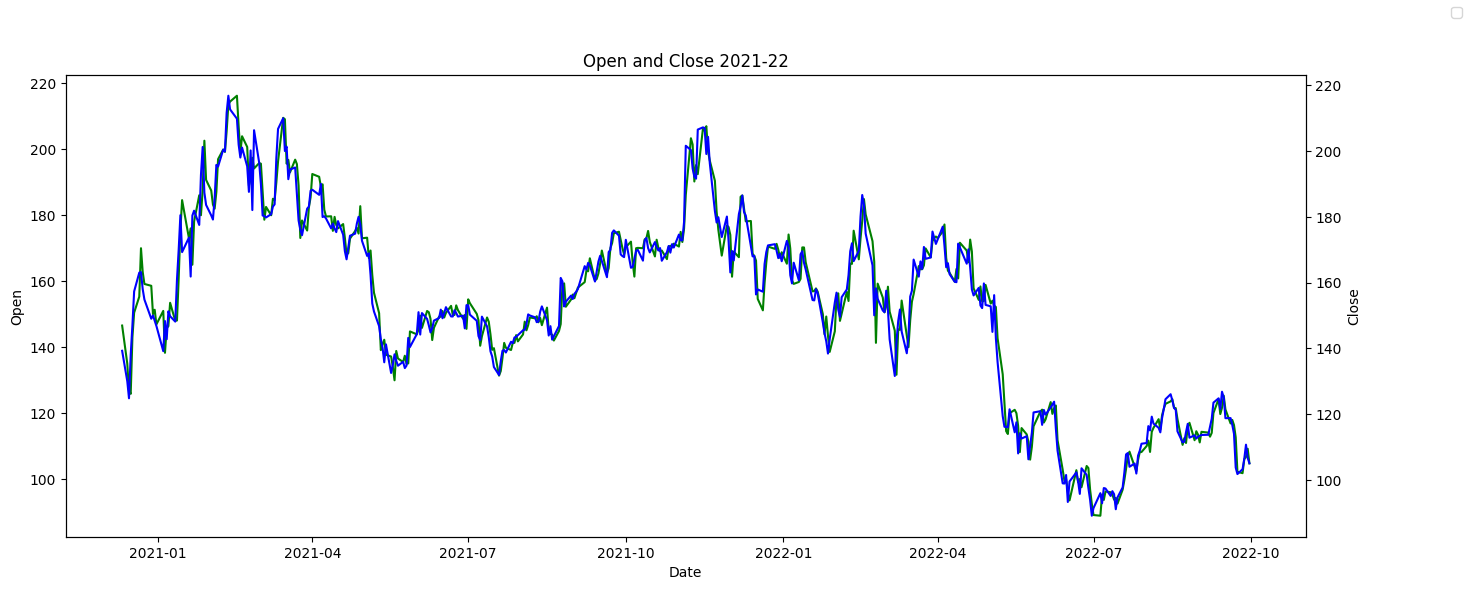

In [98]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(y='Open',x=df.index,data=df, color = 'g')
ax2 = plt.twinx()
sns.lineplot(y='Close',x=df.index,data=df, color = 'b')
plt.title("Open and Close 2021-22")
ax.figure.legend()
plt.show()

## Predicting Closing Value
We will predict the Closing value in two different ways: one where the X value is just the Low column, and one where the X value is the entire dataset excluding the Close column

### Choose X as low, y as close

In [7]:
df_tr = df[['Low', 'Close']].copy()
df_tr.head()

,Low,Close
Date,,
2020-12-11,135.100006,139.250000
2020-12-14,125.160004,130.000000
2020-12-15,121.500000,124.800003
2020-12-16,124.910004,137.990005
2020-12-17,142.669998,147.050003


Use the auxilliary function to add dates as features

In [8]:
df_tr = create_features_datetime(df_tr)
df_tr.head()

,Low,Close,Year,Month,dow
Date,,,,,
2020-12-11,135.100006,139.250000,2020,12,4
2020-12-14,125.160004,130.000000,2020,12,0
2020-12-15,121.500000,124.800003,2020,12,1
2020-12-16,124.910004,137.990005,2020,12,2
2020-12-17,142.669998,147.050003,2020,12,3


In [9]:
X = df_tr.drop('Close', axis=1)
y = df_tr[['Close']]
X

,Low,Year,Month,dow
Date,,,,
2020-12-11,135.100006,2020,12,4
2020-12-14,125.160004,2020,12,0
2020-12-15,121.500000,2020,12,1
2020-12-16,124.910004,2020,12,2
2020-12-17,142.669998,2020,12,3
...,...,...,...,...
2022-09-26,101.559998,2022,9,0
2022-09-27,104.139999,2022,9,1
2022-09-28,105.779999,2022,9,2


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((363, 4), (91, 4), (363, 1), (91, 1))

### Regression Models, No Standard Scaler
Now that the data is ready, we will use 4 different regression models to predict test data and record their performance

In [12]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [13]:
reg_1 = LinearRegression(n_jobs=-1)
reg_2 = RandomForestRegressor(n_estimators=500,n_jobs=-1)
reg_3 = LassoCV()
reg_4 = RidgeCV()

reg_list = [reg_1,reg_2, reg_3, reg_4]

In [14]:
%%time
for reg in reg_list:
    reg_name=reg.__class__.__name__
    reg.fit(X_train,y_train.values.ravel())
    print(f"Fitting {reg_name} done")
    print("-"*50)

Fitting LinearRegression done
--------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------
Fitting LassoCV done
--------------------------------------------------
Fitting RidgeCV done
--------------------------------------------------
CPU times: user 1.41 s, sys: 261 ms, total: 1.67 s
Wall time: 1.36 s


In [15]:
score_dict={}

for reg in reg_list:
    reg_name=reg.__class__.__name__
    n_coeff = X_test.shape[1] + 1
    coefficients = rand(n_coeff)
    print(coefficients)
    pred = reg.predict(X_test)
    print("~"*50)
    print(reg_name)
    print(f"R2 Score : {r2_score(y_test, pred)}")
    print(f"Mean Absolute Error Score : {mean_absolute_error(y_test,pred)}")
    print(f"Mean Sqaured Error Score : {mean_squared_error(y_test,pred)}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test,pred, squared=False)}")
    score_dict[reg_name]={
        "R2 Score":r2_score(y_test,pred),
        "Mean Absolute Error Score":mean_absolute_error(y_test,pred),
        "Mean Squared Error Score":mean_squared_error(y_test,pred),
        "Root Mean Squared Error": mean_squared_error(y_test,pred, squared=False)
    }
print("~"*50)

[0.30405272 0.16659175 0.3818854  0.84775364 0.90923463]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LinearRegression
R2 Score : 0.9848272271558094
Mean Absolute Error Score : 2.578177144298008
Mean Sqaured Error Score : 12.890078978896536
Root Mean Squared Error: 3.59027561322199
[0.53423303 0.36051489 0.55388073 0.39504375 0.24527735]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RandomForestRegressor
R2 Score : 0.9818018067209121
Mean Absolute Error Score : 2.8754180492307673
Mean Sqaured Error Score : 15.460334841200817
Root Mean Squared Error: 3.9319632298892135
[0.44416283 0.87576068 0.60753021 0.48553017 0.1183067 ]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LassoCV
R2 Score : 0.9843648396093734
Mean Absolute Error Score : 2.6321899665854684
Mean Sqaured Error Score : 13.282901836895135
Root Mean Squared Error: 3.64457155738437
[0.98792514 0.11278984 0.8106606  0.4483824  0.87997659]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RidgeCV
R2 Score : 0.9848

In [16]:
score_pd=pd.DataFrame(score_dict).transpose().sort_values("R2 Score",ascending=False)
score_pd

,R2 Score,Mean Absolute Error Score,Mean Squared Error Score,Root Mean Squared Error
LinearRegression,0.984827,2.578177,12.890079,3.590276
RidgeCV,0.984804,2.581601,12.909569,3.592989
LassoCV,0.984365,2.632190,13.282902,3.644572
RandomForestRegressor,0.981802,2.875418,15.460335,3.931963


<AxesSubplot:>

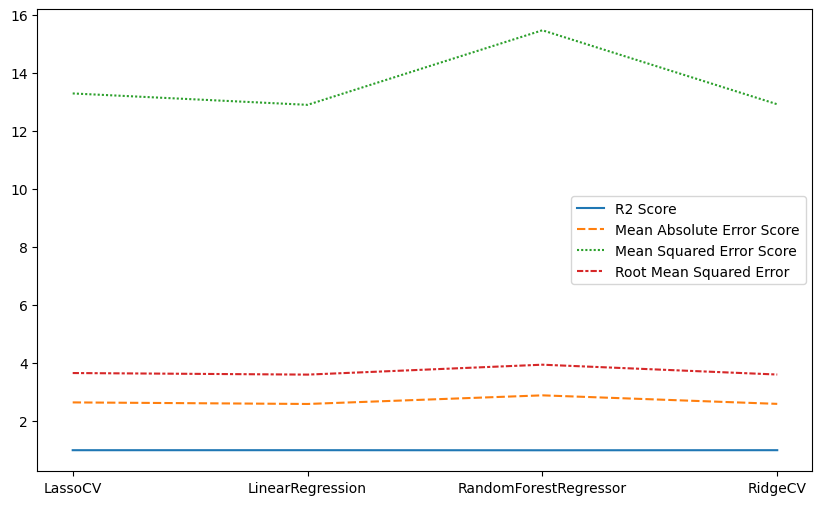

In [17]:
plt.figure(figsize=(10,6))
sns.lineplot(data=score_pd)

<AxesSubplot:xlabel='Date'>

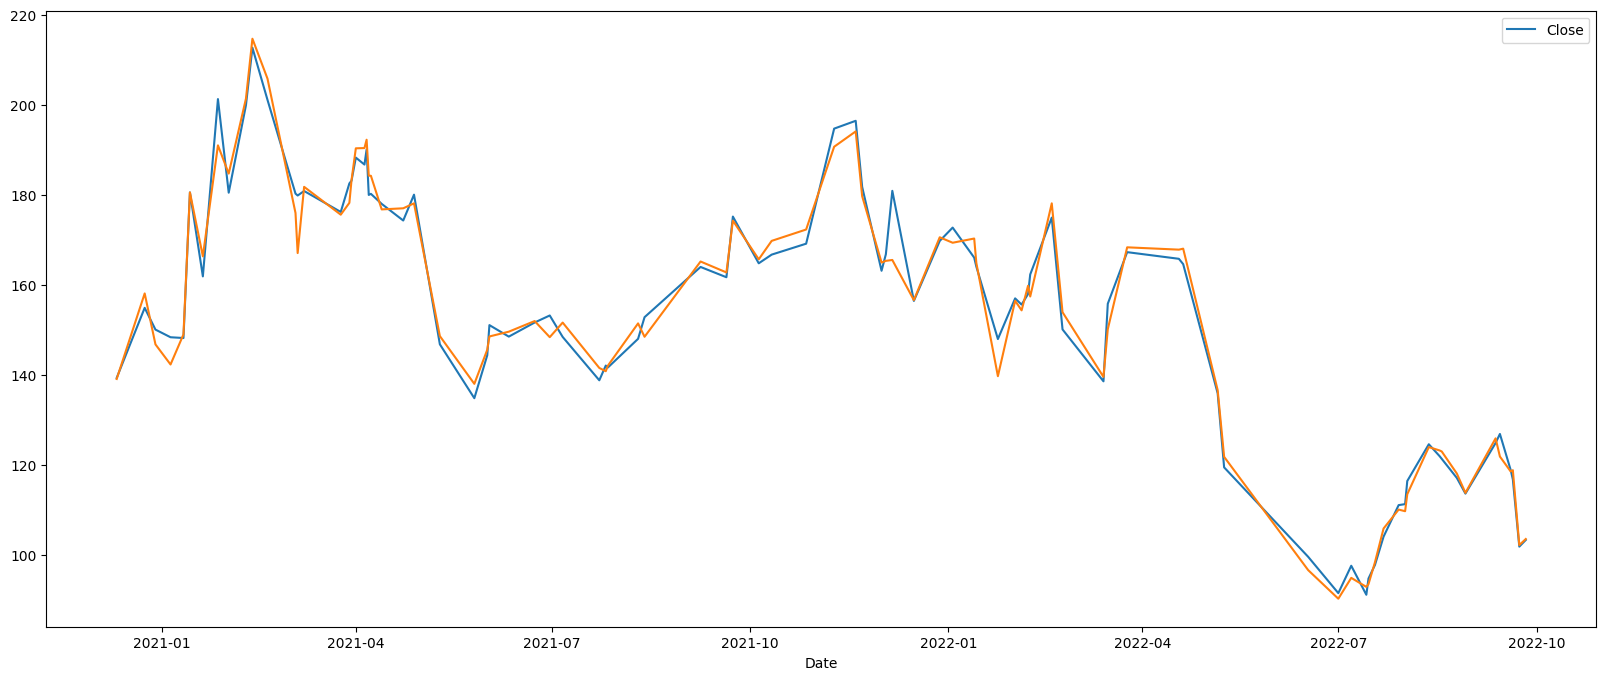

In [18]:
#predicting with linear regression
pred = reg_1.predict(X_test)
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=y_test, ax = ax)
sns.lineplot(y=pred, x = y_test.index, ax = ax)

## Principal Component Analysis for Linear Regression

Since Linear Regression performed the best, we'll apply PCA to it to optimize the model's predictions

In [19]:
model = LinearRegression()
rmse_scores = []

We scale the X values to perform PCA

In [20]:
pca = decomposition.PCA()
X_train_new = scale(X_train)
X_test_new = scale(X_test)
model = LinearRegression().fit(X_train_new, y_train)
lr_scores = -1 * cross_val_score(model, X_train_new, y_train, cv=cv, scoring='neg_root_mean_squared_error')
lr_scores

array([3.03983449, 2.83553529, 2.56370432, 2.49135423, 3.1431521 ,
       3.00802081, 4.61033241, 3.99450756, 4.81283005, 3.3136152 ])

In [21]:
lr_score_train = np.mean(lr_scores)
lr_score_train

3.3812886447721873

In [22]:
X_train_pc = pca.fit_transform(X_train_new)
X_test_pc = pca.fit_transform(X_test_new)
X_train_pc.shape

(363, 4)

In [23]:
pca.explained_variance_ratio_

array([0.39364545, 0.2924734 , 0.24892886, 0.0649523 ])

In [24]:
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(model, X_train_pc[:,:i], y_train, cv = cv, scoring='neg_root_mean_squared_error').mean()
    rmse_scores.append(rmse_score)

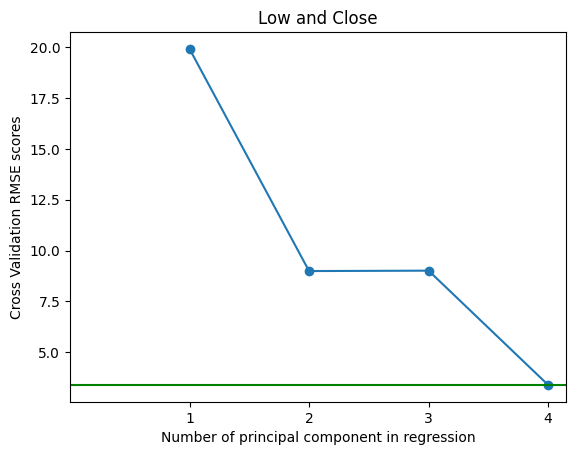

In [25]:
plt.plot(rmse_scores, '-o')
plt.xlabel('Number of principal component in regression')
plt.ylabel('Cross Validation RMSE scores')
plt.title("Low and Close")
plt.xlim(xmin=-1)
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

In [26]:
num_components = 4

### Predict with 4 Components

In [27]:
model_pc = LinearRegression().fit(X_train_pc[:,:num_components], y_train.values.ravel())
#r2 score
model_pc.score(X_train_pc[:,:num_components], y_train.values.ravel())

0.98528685897995

In [28]:
#pred = model_pc.predict(X_test_pc[:,:num_components])
pcr_score_train = -1 * cross_val_score(model_pc, 
                                       X_train_pc[:,:num_components], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()
pcr_score_train

3.3812886447721895

In [29]:
# Predict on test data
preds = model_pc.predict(X_test_pc[:,:num_components])


In [30]:
print("~"*50)
print("Linear Regression with PCA (Test)")
print(f"R2 Score : {r2_score(y_test, preds)}")
print(f"Mean Absolute Error Score : {mean_absolute_error(y_test,preds)}")
print(f"Mean Sqaured Error Score : {mean_squared_error(y_test,preds)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test,preds, squared=False)}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Linear Regression with PCA (Test)
R2 Score : -2.266967616859706
Mean Absolute Error Score : 42.25359617049145
Mean Sqaured Error Score : 2775.4630636906045
Root Mean Squared Error: 52.682663786967005


In [31]:
preds = model_pc.predict(X_train_pc[:,:num_components])
print("~"*50)
print("Linear Regression with PCA (Train)")
print(f"R2 Score : {r2_score(y_train.values.ravel(), preds)}")
print(f"Mean Absolute Error Score : {mean_absolute_error(y_train.values.ravel(),preds)}")
print(f"Mean Sqaured Error Score : {mean_squared_error(y_train.values.ravel(),preds)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train.values.ravel(),preds, squared=False)}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Linear Regression with PCA (Train)
R2 Score : 0.98528685897995
Mean Absolute Error Score : 2.4225321868671714
Mean Sqaured Error Score : 11.495495312492324
Root Mean Squared Error: 3.390500746570088


After applying PCA to the X values, we see that the R2 score improved for the training set, but the model did overall much worse on the testing set. Perhaps this means the model is overfitting.

## X is rest of dataset, y is close
Since the adjusted close column is very similar to the close column, it will give us a perfect model r2 score of 1. Using this column would not yield any valuable results, so it won't be included in the X values.

In [32]:
df_n = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
df_n.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-12-11,146.550003,151.500000,135.100006,139.250000,26980800
2020-12-14,135.000000,135.300003,125.160004,130.000000,16966100
2020-12-15,126.690002,127.599998,121.500000,124.800003,10914400
2020-12-16,125.830002,142.000000,124.910004,137.990005,20409600
2020-12-17,143.000000,152.449997,142.669998,147.050003,15054700


In [33]:
df_n = create_features_datetime(df_n)
df_n.head()

,Open,High,Low,Close,Volume,Year,Month,dow
Date,,,,,,,,
2020-12-11,146.550003,151.500000,135.100006,139.250000,26980800,2020,12,4
2020-12-14,135.000000,135.300003,125.160004,130.000000,16966100,2020,12,0
2020-12-15,126.690002,127.599998,121.500000,124.800003,10914400,2020,12,1
2020-12-16,125.830002,142.000000,124.910004,137.990005,20409600,2020,12,2
2020-12-17,143.000000,152.449997,142.669998,147.050003,15054700,2020,12,3


In [34]:
X = df_n.drop('Close', axis=1)
y = df_n[['Close']]
X

,Open,High,Low,Volume,Year,Month,dow
Date,,,,,,,
2020-12-11,146.550003,151.500000,135.100006,26980800,2020,12,4
2020-12-14,135.000000,135.300003,125.160004,16966100,2020,12,0
2020-12-15,126.690002,127.599998,121.500000,10914400,2020,12,1
2020-12-16,125.830002,142.000000,124.910004,20409600,2020,12,2
2020-12-17,143.000000,152.449997,142.669998,15054700,2020,12,3
...,...,...,...,...,...,...,...
2022-09-26,101.779999,105.360001,101.559998,5278800,2022,9,0
2022-09-27,106.040001,108.169998,104.139999,5081000,2022,9,1
2022-09-28,106.700996,111.129997,105.779999,4518200,2022,9,2


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((363, 7), (91, 7), (363, 1), (91, 1))

### Regression Models

In [36]:
reg_1 = LinearRegression(n_jobs=-1)
reg_2 = RandomForestRegressor(n_estimators=500,n_jobs=-1)
reg_3 = LassoCV()
reg_4 = RidgeCV()

reg_list = [reg_1,reg_2, reg_3, reg_4]

In [37]:
%%time
for reg in reg_list:
    reg_name=reg.__class__.__name__
    reg.fit(X_train,y_train.values.ravel())
    print(f"Fitting {reg_name} done")
    print("-"*50)

Fitting LinearRegression done
--------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------
Fitting LassoCV done
--------------------------------------------------
Fitting RidgeCV done
--------------------------------------------------
CPU times: user 1.54 s, sys: 197 ms, total: 1.73 s
Wall time: 1.2 s


In [38]:
score_dict={}

for reg in reg_list:
    reg_name=reg.__class__.__name__
    n_coeff = X_test.shape[1] + 1
    coefficients = rand(n_coeff)
    print(coefficients)
    pred = reg.predict(X_test)
    print("~"*50)
    print(reg_name)
    print(f"R2 Score : {r2_score(y_test, pred)}")
    print(f"Mean Absolute Error Score : {mean_absolute_error(y_test,pred)}")
    print(f"Mean Sqaured Error Score : {mean_squared_error(y_test,pred)}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test,pred, squared=False)}")
    score_dict[reg_name]={
        "R2 Score":r2_score(y_test,pred),
        "Mean Absolute Error Score":mean_absolute_error(y_test,pred),
        "Mean Squared Error Score":mean_squared_error(y_test,pred),
        "Root Mean Squared Error": mean_squared_error(y_test,pred, squared=False)
    }
print("~"*50)

[0.31925854 0.34941047 0.70172766 0.33092094 0.69865449 0.87889748
 0.58726318 0.77206543]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LinearRegression
R2 Score : 0.9912855022733954
Mean Absolute Error Score : 1.8771671552634135
Mean Sqaured Error Score : 7.403430151553097
Root Mean Squared Error: 2.720924503096897
[0.12087952 0.01613407 0.55990971 0.37708319 0.03220798 0.63230443
 0.63344003 0.14594556]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RandomForestRegressor
R2 Score : 0.9861919329781494
Mean Absolute Error Score : 2.519191873560442
Mean Sqaured Error Score : 11.730688667477043
Root Mean Squared Error: 3.425009294509585
[0.50586197 0.47267142 0.59348466 0.45080662 0.44230521 0.81743758
 0.23800173 0.22707438]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LassoCV
R2 Score : 0.023572175619934965
Mean Absolute Error Score : 23.22168265745844
Mean Sqaured Error Score : 829.5274636152062
Root Mean Squared Error: 28.80151842551372
[0.6285492  0.96612191 0.559927

In [39]:
score_pd=pd.DataFrame(score_dict).transpose().sort_values("R2 Score",ascending=False)
score_pd

,R2 Score,Mean Absolute Error Score,Mean Squared Error Score,Root Mean Squared Error
LinearRegression,0.991286,1.877167,7.403430,2.720925
RandomForestRegressor,0.986192,2.519192,11.730689,3.425009
RidgeCV,0.986080,2.524728,11.826082,3.438907
LassoCV,0.023572,23.221683,829.527464,28.801518


From the table above we see that Linear Regression once again outperformed the rest of the models. The rest of the models did almost the same except the LassoCV model.

## Principal Component Analysis with Linear Regression (2)

In [40]:
model = LinearRegression()
rmse_scores = []

In [41]:
pca = decomposition.PCA()
X_train_new = scale(X_train)
X_test_new = scale(X_test)
X_train_new = scale(X_train)
X_test_new = scale(X_test)
model = LinearRegression().fit(X_train_new, y_train)
lr_scores = -1 * cross_val_score(model, X_train_new, y_train, cv=cv, scoring='neg_root_mean_squared_error')
lr_score_train = np.mean(lr_scores)
lr_score_train

2.1443063219188785

In [42]:
X_train_pc = pca.fit_transform(X_train_new)
X_test_pc = pca.fit_transform(X_test_new)
X_train_pc.shape

(363, 7)

In [43]:
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(model, X_train_pc[:,:i], y_train, cv = cv, scoring='neg_root_mean_squared_error').mean()
    rmse_scores.append(rmse_score)

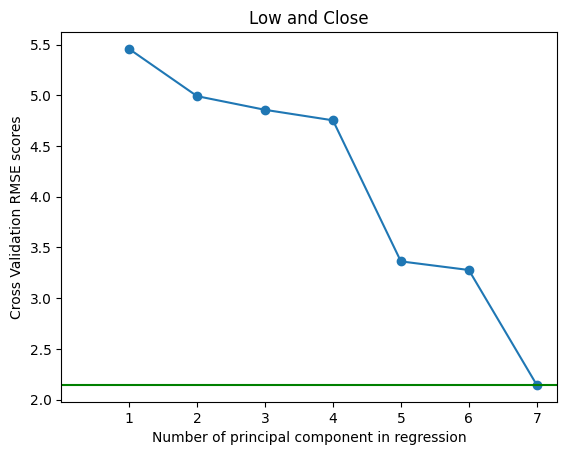

In [44]:
plt.plot(rmse_scores, '-o')
plt.xlabel('Number of principal component in regression')
plt.ylabel('Cross Validation RMSE scores')
plt.title("Low and Close")
plt.xlim(xmin=-1)
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle="-");

### Predict with 7 components

In [45]:
num_components = 7

In [46]:
model_pc = LinearRegression().fit(X_train_pc[:,:num_components], y_train.values.ravel())
#r2 score
model_pc.score(X_train_pc[:,:num_components], y_train.values.ravel())

0.994427075868242

In [47]:
pcr_score_train = -1 * cross_val_score(model_pc, 
                                       X_train_pc[:,:num_components], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()
pcr_score_train

2.144306321918883

In [48]:
preds = model_pc.predict(X_test_pc[:,:num_components])

In [49]:
print("~"*50)
print("Linear Regression with PCA (Test)")
print(f"R2 Score : {r2_score(y_test, preds)}")
print(f"Mean Absolute Error Score : {mean_absolute_error(y_test,preds)}")
print(f"Mean Sqaured Error Score : {mean_squared_error(y_test,preds)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test,preds, squared=False)}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Linear Regression with PCA (Test)
R2 Score : 0.9209425439008043
Mean Absolute Error Score : 6.255387684453639
Mean Sqaured Error Score : 67.16352135855341
Root Mean Squared Error: 8.195335341433772


In [50]:
preds = model_pc.predict(X_train_pc[:,:num_components])
print("~"*50)
print("Linear Regression with PCA (Train)")
print(f"R2 Score : {r2_score(y_train.values.ravel(), preds)}")
print(f"Mean Absolute Error Score : {mean_absolute_error(y_train.values.ravel(),preds)}")
print(f"Mean Sqaured Error Score : {mean_squared_error(y_train.values.ravel(),preds)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train.values.ravel(),preds, squared=False)}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Linear Regression with PCA (Train)
R2 Score : 0.994427075868242
Mean Absolute Error Score : 1.552521154308507
Mean Sqaured Error Score : 4.35417040767834
Root Mean Squared Error: 2.0866649006676514


The PCA tuned Linear Regression Model seemed to underperform in comparison to the original model when given test data. The R2 score is slightly less, but the Mean Squared Error is much higher. 
However, the model performed much better when given the training data, indicating that the model may be overfitting.

## Predicting Highest Value

To predict the highest value I'll use the open column.

In [51]:
df_tr = df[['Open', 'High']].copy()
df_tr.head()

,Open,High
Date,,
2020-12-11,146.550003,151.500000
2020-12-14,135.000000,135.300003
2020-12-15,126.690002,127.599998
2020-12-16,125.830002,142.000000
2020-12-17,143.000000,152.449997


In [52]:
df_tr = create_features_datetime(df_tr)
df_tr.head()

,Open,High,Year,Month,dow
Date,,,,,
2020-12-11,146.550003,151.500000,2020,12,4
2020-12-14,135.000000,135.300003,2020,12,0
2020-12-15,126.690002,127.599998,2020,12,1
2020-12-16,125.830002,142.000000,2020,12,2
2020-12-17,143.000000,152.449997,2020,12,3


In [53]:
X = df_tr.drop('High', axis=1)
y = df_tr[['High']]
X

,Open,Year,Month,dow
Date,,,,
2020-12-11,146.550003,2020,12,4
2020-12-14,135.000000,2020,12,0
2020-12-15,126.690002,2020,12,1
2020-12-16,125.830002,2020,12,2
2020-12-17,143.000000,2020,12,3
...,...,...,...,...
2022-09-26,101.779999,2022,9,0
2022-09-27,106.040001,2022,9,1
2022-09-28,106.700996,2022,9,2


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((363, 4), (91, 4), (363, 1), (91, 1))

### Regression Models

In [56]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [57]:
reg_1 = LinearRegression(n_jobs=-1)
reg_2 = RandomForestRegressor(n_estimators=500,n_jobs=-1)
reg_3 = LassoCV()
reg_4 = RidgeCV()

reg_list = [reg_1,reg_2, reg_3, reg_4]

In [58]:
%%time
for reg in reg_list:
    reg_name=reg.__class__.__name__
    reg.fit(X_train,y_train.values.ravel())
    print(f"Fitting {reg_name} done")
    print("-"*50)

Fitting LinearRegression done
--------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------
Fitting LassoCV done
--------------------------------------------------
Fitting RidgeCV done
--------------------------------------------------
CPU times: user 1.32 s, sys: 210 ms, total: 1.53 s
Wall time: 1.25 s


In [59]:
score_dict={}

for reg in reg_list:
    reg_name=reg.__class__.__name__
    n_coeff = X_test.shape[1] + 1
    coefficients = rand(n_coeff)
    print(coefficients)
    pred = reg.predict(X_test)
    print("~"*50)
    print(reg_name)
    print(f"R2 Score : {r2_score(y_test, pred)}")
    print(f"Mean Absolute Error Score : {mean_absolute_error(y_test,pred)}")
    print(f"Mean Sqaured Error Score : {mean_squared_error(y_test,pred)}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test,pred, squared=False)}")
    score_dict[reg_name]={
        "R2 Score":r2_score(y_test,pred),
        "Mean Absolute Error Score":mean_absolute_error(y_test,pred),
        "Mean Squared Error Score":mean_squared_error(y_test,pred),
        "Root Mean Squared Error": mean_squared_error(y_test,pred, squared=False)
    }
print("~"*50)

[0.78415813 0.03571602 0.19091042 0.08697122 0.80515881]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LinearRegression
R2 Score : 0.9837436856185593
Mean Absolute Error Score : 2.718289649632837
Mean Sqaured Error Score : 15.121123859837086
Root Mean Squared Error: 3.888588929140889
[1.26001741e-04 6.85884781e-01 2.35450108e-01 7.46447531e-01
 1.42502146e-01]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RandomForestRegressor
R2 Score : 0.9760407484482194
Mean Absolute Error Score : 3.373074260882283
Mean Sqaured Error Score : 22.286159199595836
Root Mean Squared Error: 4.720821877554356
[0.11632372 0.11897509 0.10136172 0.65998041 0.40344663]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LassoCV
R2 Score : 0.9833990739803596
Mean Absolute Error Score : 2.697074495416601
Mean Sqaured Error Score : 15.44167101108476
Root Mean Squared Error: 3.9295891656870134
[0.34869833 0.19185997 0.85632079 0.53385414 0.72349317]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ridge

In [60]:
score_pd=pd.DataFrame(score_dict).transpose().sort_values("R2 Score",ascending=False)
score_pd

,R2 Score,Mean Absolute Error Score,Mean Squared Error Score,Root Mean Squared Error
LinearRegression,0.983744,2.718290,15.121124,3.888589
RidgeCV,0.983710,2.719721,15.152020,3.892560
LassoCV,0.983399,2.697074,15.441671,3.929589
RandomForestRegressor,0.976041,3.373074,22.286159,4.720822


Linear Regression outperforms the rest of the models, so we'll apply PCA to this model

### Principal Component Analysis for Linear Regression (High)

In [61]:
model = LinearRegression()
rmse_scores = []

In [62]:
pca = decomposition.PCA()
X_train_new = scale(X_train)
X_test_new = scale(X_test)
model = LinearRegression().fit(X_train_new, y_train)
lr_scores = -1 * cross_val_score(model, X_train_new, y_train, cv=cv, scoring='neg_root_mean_squared_error')
lr_scores

array([3.37347742, 2.37206701, 2.41274656, 2.76738878, 2.69941931,
       3.18412038, 5.13534756, 4.24743886, 4.02693803, 3.75972521])

In [63]:
lr_score_train = np.mean(lr_scores)
lr_score_train

3.39786691230483

In [64]:
X_train_pc = pca.fit_transform(X_train_new)
X_test_pc = pca.fit_transform(X_test_new)
X_train_pc.shape

(363, 4)

In [65]:
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(model, X_train_pc[:,:i], y_train, cv = cv, scoring='neg_root_mean_squared_error').mean()
    rmse_scores.append(rmse_score)

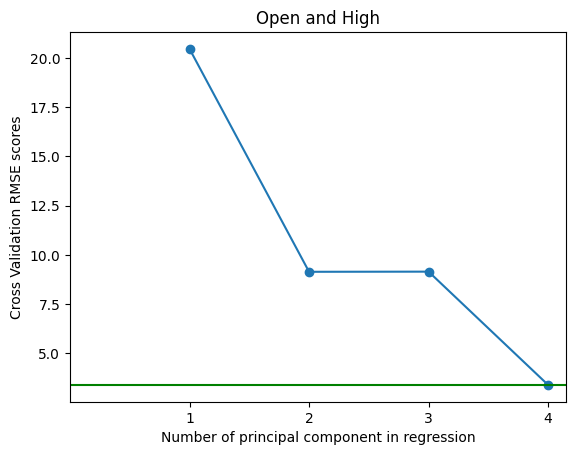

In [66]:
plt.plot(rmse_scores, '-o')
plt.xlabel('Number of principal component in regression')
plt.ylabel('Cross Validation RMSE scores')
plt.title("Open and High")
plt.xlim(xmin=-1)
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

In [67]:
num_components = 4

### Predict with 4 components

In [68]:
model_pc = LinearRegression().fit(X_train_pc[:,:num_components], y_train.values.ravel())
#r2 score
model_pc.score(X_train_pc[:,:num_components], y_train.values.ravel())

0.9857355733624092

In [69]:
#pred = model_pc.predict(X_test_pc[:,:num_components])
pcr_score_train = -1 * cross_val_score(model_pc, 
                                       X_train_pc[:,:num_components], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()
pcr_score_train

3.397866912304834

In [70]:
preds = model_pc.predict(X_test_pc[:,:num_components])


In [71]:
print("~"*50)
print("Linear Regression with PCA (Test)")
print(f"R2 Score : {r2_score(y_test, preds)}")
print(f"Mean Absolute Error Score : {mean_absolute_error(y_test,preds)}")
print(f"Mean Sqaured Error Score : {mean_squared_error(y_test,preds)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test,preds, squared=False)}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Linear Regression with PCA (Test)
R2 Score : -2.2239379757103137
Mean Absolute Error Score : 43.359688570645
Mean Sqaured Error Score : 2998.8079895159876
Root Mean Squared Error: 54.761373152213665


In [72]:
preds = model_pc.predict(X_train_pc[:,:num_components])
print("~"*50)
print("Linear Regression with PCA (Train)")
print(f"R2 Score : {r2_score(y_train.values.ravel(), preds)}")
print(f"Mean Absolute Error Score : {mean_absolute_error(y_train.values.ravel(),preds)}")
print(f"Mean Sqaured Error Score : {mean_squared_error(y_train.values.ravel(),preds)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train.values.ravel(),preds, squared=False)}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Linear Regression with PCA (Train)
R2 Score : 0.9857355733624092
Mean Absolute Error Score : 2.453427213559266
Mean Sqaured Error Score : 11.755814582018795
Root Mean Squared Error: 3.4286753392554967


The Linear Regression model perfroms slightly better for the training data, but did much worse for the test data. This model seems to be extremely overfitting the training data.

## Predicting Highest value using rest of data
Now we predict the Highest stock value using the rest of the dataset

In [74]:
df_n = df.copy()
df_n.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800
2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100
2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400
2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600
2020-12-17,143.000000,152.449997,142.669998,147.050003,147.050003,15054700


In [75]:
df_n = create_features_datetime(df_n)
df_n.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,dow
Date,,,,,,,,,
2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800,2020,12,4
2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100,2020,12,0
2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400,2020,12,1
2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600,2020,12,2
2020-12-17,143.000000,152.449997,142.669998,147.050003,147.050003,15054700,2020,12,3


In [77]:
X = df_n.drop('High', axis=1)
y = df_n[['High']]
X

,Open,Low,Close,Adj Close,Volume,Year,Month,dow
Date,,,,,,,,
2020-12-11,146.550003,135.100006,139.250000,139.250000,26980800,2020,12,4
2020-12-14,135.000000,125.160004,130.000000,130.000000,16966100,2020,12,0
2020-12-15,126.690002,121.500000,124.800003,124.800003,10914400,2020,12,1
2020-12-16,125.830002,124.910004,137.990005,137.990005,20409600,2020,12,2
2020-12-17,143.000000,142.669998,147.050003,147.050003,15054700,2020,12,3
...,...,...,...,...,...,...,...,...
2022-09-26,101.779999,101.559998,103.230003,103.230003,5278800,2022,9,0
2022-09-27,106.040001,104.139999,106.370003,106.370003,5081000,2022,9,1
2022-09-28,106.700996,105.779999,110.690002,110.690002,4518200,2022,9,2


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((363, 8), (91, 8), (363, 1), (91, 1))

### Regression Models

In [80]:
reg_1 = LinearRegression(n_jobs=-1)
reg_2 = RandomForestRegressor(n_estimators=500,n_jobs=-1)
reg_3 = LassoCV()
reg_4 = RidgeCV()

reg_list = [reg_1,reg_2, reg_3, reg_4]

In [81]:
%%time
for reg in reg_list:
    reg_name=reg.__class__.__name__
    reg.fit(X_train,y_train.values.ravel())
    print(f"Fitting {reg_name} done")
    print("-"*50)

Fitting LinearRegression done
--------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------
Fitting LassoCV done
--------------------------------------------------
Fitting RidgeCV done
--------------------------------------------------
CPU times: user 1.62 s, sys: 235 ms, total: 1.85 s
Wall time: 1.35 s


In [82]:
score_dict={}

for reg in reg_list:
    reg_name=reg.__class__.__name__
    n_coeff = X_test.shape[1] + 1
    coefficients = rand(n_coeff)
    print(coefficients)
    pred = reg.predict(X_test)
    print("~"*50)
    print(reg_name)
    print(f"R2 Score : {r2_score(y_test, pred)}")
    print(f"Mean Absolute Error Score : {mean_absolute_error(y_test,pred)}")
    print(f"Mean Sqaured Error Score : {mean_squared_error(y_test,pred)}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test,pred, squared=False)}")
    score_dict[reg_name]={
        "R2 Score":r2_score(y_test,pred),
        "Mean Absolute Error Score":mean_absolute_error(y_test,pred),
        "Mean Squared Error Score":mean_squared_error(y_test,pred),
        "Root Mean Squared Error": mean_squared_error(y_test,pred, squared=False)
    }
print("~"*50)

[0.83768669 0.41884056 0.80643034 0.28539676 0.4930908  0.96322732
 0.2001326  0.25790446 0.65355961]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LinearRegression
R2 Score : 0.9932599473199019
Mean Absolute Error Score : 1.603639554636671
Mean Sqaured Error Score : 6.269389789480566
Root Mean Squared Error: 2.503874954841109
[0.37308288 0.2251062  0.48378179 0.97377012 0.20922761 0.04017058
 0.84911364 0.49363798 0.89492885]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RandomForestRegressor
R2 Score : 0.9922844822961335
Mean Absolute Error Score : 1.7755830755604234
Mean Sqaured Error Score : 7.176737365274205
Root Mean Squared Error: 2.6789433299855756
[0.35150996 0.26436866 0.70695518 0.5764076  0.68168209 0.28493862
 0.80869321 0.29443086 0.8539981 ]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LassoCV
R2 Score : 0.014064155125514843
Mean Absolute Error Score : 24.62284100397383
Mean Sqaured Error Score : 917.0872116757712
Root Mean Squared Error: 30.2834478168482

In [83]:
score_pd=pd.DataFrame(score_dict).transpose().sort_values("R2 Score",ascending=False)
score_pd

,R2 Score,Mean Absolute Error Score,Mean Squared Error Score,Root Mean Squared Error
LinearRegression,0.993260,1.603640,6.269390,2.503875
RandomForestRegressor,0.992284,1.775583,7.176737,2.678943
RidgeCV,0.992118,1.778758,7.331813,2.707732
LassoCV,0.014064,24.622841,917.087212,30.283448


### Principal Component Analysis with Linear Regression (High) (2)

In [84]:
model = LinearRegression()
rmse_scores = []

In [85]:
pca = decomposition.PCA()
X_train_new = scale(X_train)
X_test_new = scale(X_test)
X_train_new = scale(X_train)
X_test_new = scale(X_test)
model = LinearRegression().fit(X_train_new, y_train)
lr_scores = -1 * cross_val_score(model, X_train_new, y_train, cv=cv, scoring='neg_root_mean_squared_error')
lr_score_train = np.mean(lr_scores)
lr_score_train

1.9940379308229232

In [86]:
X_train_pc = pca.fit_transform(X_train_new)
X_test_pc = pca.fit_transform(X_test_new)
X_train_pc.shape

(363, 8)

In [87]:
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(model, X_train_pc[:,:i], y_train, cv = cv, scoring='neg_root_mean_squared_error').mean()
    rmse_scores.append(rmse_score)

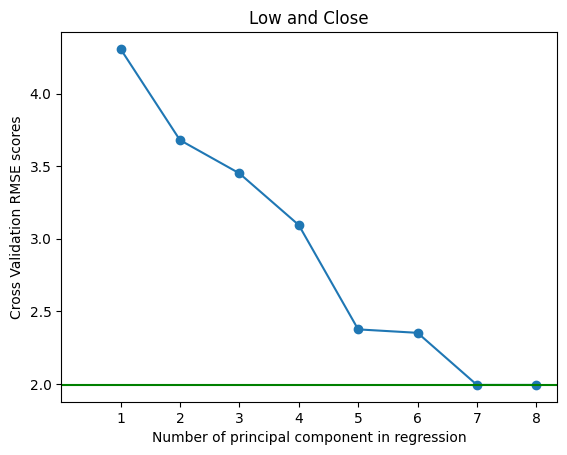

In [88]:
plt.plot(rmse_scores, '-o')
plt.xlabel('Number of principal component in regression')
plt.ylabel('Cross Validation RMSE scores')
plt.title("Low and Close")
plt.xlim(xmin=-1)
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle="-");

### Predict with 7 components

In [89]:
num_components = 7

In [90]:
model_pc = LinearRegression().fit(X_train_pc[:,:num_components], y_train.values.ravel())
#r2 score
model_pc.score(X_train_pc[:,:num_components], y_train.values.ravel())

0.995574987486123

In [91]:
pcr_score_train = -1 * cross_val_score(model_pc, 
                                       X_train_pc[:,:num_components], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()
pcr_score_train

1.994037930822922

In [92]:
preds = model_pc.predict(X_test_pc[:,:num_components])

In [93]:
print("~"*50)
print("Linear Regression with PCA (Test)")
print(f"R2 Score : {r2_score(y_test, preds)}")
print(f"Mean Absolute Error Score : {mean_absolute_error(y_test,preds)}")
print(f"Mean Sqaured Error Score : {mean_squared_error(y_test,preds)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test,preds, squared=False)}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Linear Regression with PCA (Test)
R2 Score : 0.955993055260009
Mean Absolute Error Score : 4.7736437735265405
Mean Sqaured Error Score : 40.93390706482117
Root Mean Squared Error: 6.397961164685292


In [94]:
preds = model_pc.predict(X_train_pc[:,:num_components])
print("~"*50)
print("Linear Regression with PCA (Train)")
print(f"R2 Score : {r2_score(y_train.values.ravel(), preds)}")
print(f"Mean Absolute Error Score : {mean_absolute_error(y_train.values.ravel(),preds)}")
print(f"Mean Sqaured Error Score : {mean_squared_error(y_train.values.ravel(),preds)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train.values.ravel(),preds, squared=False)}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Linear Regression with PCA (Train)
R2 Score : 0.995574987486123
Mean Absolute Error Score : 1.3562202248719613
Mean Sqaured Error Score : 3.6468081022733796
Root Mean Squared Error: 1.9096617769315538


From the results above the PCA tuned Linear Regression Model did not perform as well for the test data as the training, but it did much better than the previous models worked on. The worst score for it seems to be the Mean Squared Error of 40.933

<AxesSubplot:xlabel='Date'>

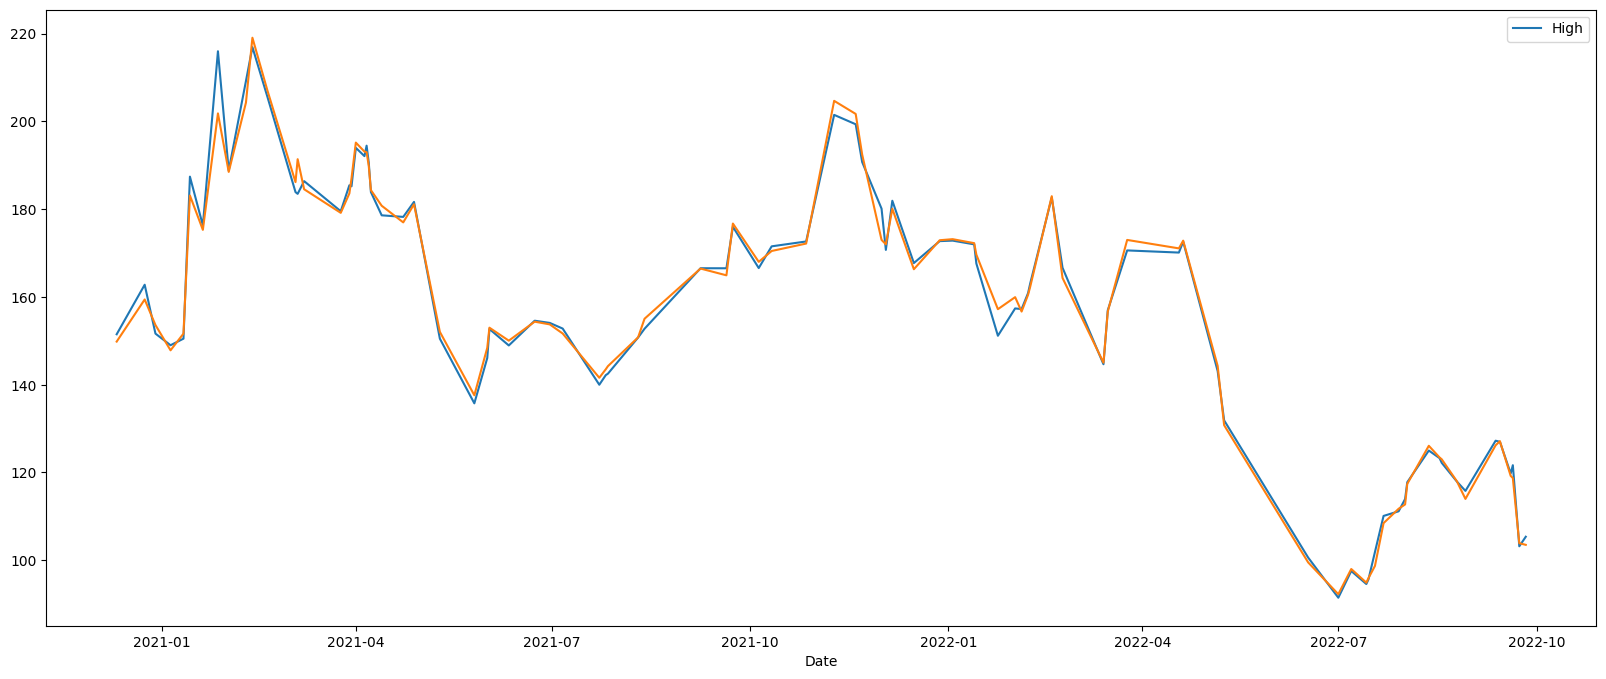

In [95]:
#predicting with linear regression
pred = reg_1.predict(X_test)
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=y_test, ax = ax)
sns.lineplot(y=pred, x = y_test.index, ax = ax)